In [2]:
# Austin Griffith
# Sf Values for American Put Option
# Python 3.6.5
# 4/1/2018

import pandas as pd
import numpy as np
from math import exp, log, sqrt, pi
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

In [3]:
# motion of binomial tree
def direction(dt,mu,div=0.0):
    u = (1 + sigma*sqrt(dt))*(1 - div*dt)
    d = (1 - sigma*sqrt(dt))*(1 - div*dt)
    p = 0.5*(1 + mu*sqrt(dt)/sigma)
    return(u,d,p)

# create binomial tree of underlying asset value
# uses pandas to allow for easy intrinsic valuation for calls and puts
def tree(S0,m,up,down):
    bi = pd.DataFrame([S0])
    for step in range(1,m+1):
        temp = bi[step-1]
        bi0 = []
        size = len(temp)-1
        for i,t in enumerate(temp):
            if i == size:
                bi0.append(up*t)
                bi0.append(down*t)
            else:
                bi0.append(up*t)
        bi0 = pd.DataFrame(bi0)
        bi0.columns = [step]
        bi = pd.concat([bi,bi0],axis=1)
    return(bi)

# intrinsic for euro and american option valuation
class Intrinsic():
    def __init__(self,binomial):
        put = K - binomial
        put[put < 0] = 0
        self.intPut = put

        call = binomial - K
        call[call < 0] = 0
        self.intCall = call

# changes binomial dataframe tree to list tree
def to_list(data):
    treeList = []
    idx = data.columns
    for x in idx:
        temp = data[x]
        temp = temp.dropna(axis=0,how='all')
        temp = list(temp)
        treeList.append(temp)
    return(treeList)

# changes binomial list to dataframe data
def to_tree(data):
    treeFrame = pd.DataFrame([])
    for i in data:
        temp = pd.DataFrame(i)
        treeFrame = pd.concat([treeFrame,temp],axis=1)
    return(treeFrame)

In [4]:
# BS pricing of European Call and Put
class bs_price:
    def __init__(self,S,K,T,r,sigma,div=0.0):
        N = norm.cdf
        d1 = (log(S/K) + (r - div + 0.5*(sigma**2))*T)/(sigma*sqrt(T))
        d2 = d1 - sigma*sqrt(T)
        
        self.call = S*exp(-div*T)*N(d1) - K*exp(-r*T)*N(d2)
        self.put = K*exp(-r*T)*N(-d2) - S*exp(-div*T)*N(-d1)

# Calculating the values of options through binomial tree lattice
class Tree:
    def __init__(self,r,mu,m,dt,S0,div=0.0,option='put'):
        self.m = m
        self.r = r
        self.mu = mu
        self.dt = dt
        self.div = div
        self.S0 = S0
        self.option = option

        # set up directions for tree
        u,d,p = direction(dt,mu,div)
        self.prob = p
        self.up = u
        self.down = d

        # create binomial tree and intrinsic values
        self.binomial = tree(S0,m,u,d)
        intTree = Intrinsic(self.binomial)

        
        # set intrinsic to put or call
        # solve for black scholes of call or put
        if option == 'put':
            # put intrinsic
            self.intData = intTree.intPut
            self.intDataList = to_list(intTree.intPut)
        else:
            # call intrinsic
            self.intData = intTree.intCall
            self.intDataList = to_list(intTree.intCall)

        # intrinsic value at t = 0
        self.intValue = self.intDataList[0][0]

        # reversed trees
        self.euroRevTree = []
        self.amerRevTree = []

        # prices of each option from the binomial trees
        self.amerPrice = 0.0
        self.euroPrice = 0.0

        # Sf value list
        self.sfList = []

    # reverse valuation through European tree value
    def revEuro(self):
        M = list(range(0,self.m))
        endVals = self.intDataList[len(self.intDataList)-1]

        value = []
        value.append(endVals)

        for step in M:
            v0 = value[step]
            vStep = []
            for i in range(0,len(v0)-1):
                temp = (v0[i]*self.prob + (1-self.prob)*v0[i+1])*(1 + self.r/self.m)**-self.dt
                vStep.append(temp)
            value.append(vStep)

        # update reversed tree and price
        self.euroRevTree = value
        self.euroPrice = value[len(value)-1][0]

    # reverse valuation through American tree value
    def revAmer(self):
        M = list(range(0,self.m))
        endVals = self.intDataList[len(self.intDataList)-1]

        # reverse intrinsic data for time state comparison
        # required for American option
        intDataRev = self.intDataList*1
        intDataRev.reverse()

        value = []
        value.append(endVals)

        for step in M:
            v0 = value[step]
            v1 = intDataRev[step+1]
            vStep = []
            for i in range(0,len(v0)-1):
                temp0 = (v0[i]*self.prob + (1-self.prob)*v0[i+1])*(1 + self.r/self.m)**-self.dt
                temp1 = v1[i]
                vStep.append(max(temp0,temp1))
            value.append(vStep)

        # update reversed tree and price
        self.amerRevTree = value
        self.amerPrice = value[len(value)-1][0]

    # calculate Sf values for American tree
    def Sf(self,times):
        biList = to_list(self.binomial)
        amerList = self.amerRevTree*1
        amerList.reverse()

        # create a true/false check on whether intrinsic was used
        intUsed = []
        for t in range(0,len(biList)):
            check = np.equal(self.intDataList[t],[i+1 if i == 0 else i for i in amerList[t]])
            checkValue = np.multiply(check,1)
            intUsed.append(checkValue)
        
        # solves for sf for put option
        if self.option == 'put':
            sf = []
            for t in times:
                sft = max(np.multiply(biList[t],intUsed[t]))
                sf.append(sft)
            self.sfList = sf
            
        # solves for sf for call option
        else:
            sf = []
            for t in times:
                sf_check = np.multiply(biList[t],intUsed[t])
                # change to array and check for nonzero elements
                # if empty, then you know that the value is zero for that time
                temp = np.array(sf_check)
                sft = temp[temp.nonzero()]
                if sft.size > 0:
                    sftList = list(sft)
                    sf.append(min(sftList))
                else:
                    sf.append(0.0)
            self.sfList = sf
                    

In [5]:
# initial values
sigma = 0.5
r = 0.15
mu = 0.1
T = 1.0

m = 100
dt = T/m
K = 5.0
div = 0.0

# set spot price range
steps = 0.1
S = np.arange(steps,7+steps,steps)
S = np.around(S,1)

In [6]:
# time intervals to iterate with Sf
times = np.linspace(0,95,20)
times = times.astype(int)

In [7]:
# collection of put values across underlyings
amerPutVals = []
euroPutVals = []
intVals = []
sfVals = []
optType = 'put'

for stockVals in S:
    trees = Tree(r,mu,m,dt,stockVals,div,optType)
    trees.revEuro()
    trees.revAmer()
    euroPutVals.append(trees.euroPrice)
    amerPutVals.append(trees.amerPrice)
    intVals.append(trees.intValue)

    trees.Sf(times)
    sfVals.append(trees.sfList)

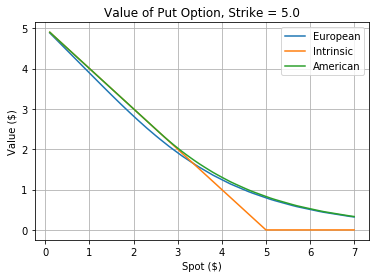

In [8]:
# plot of American, European and Intrinsic put values
plt.title('Value of Put Option, Strike = '+str(K))
plt.xlabel('Spot ($)')
plt.ylabel('Value ($)')
plt.plot(S,euroPutVals,label='European')
plt.plot(S,intVals,label='Intrinsic')
plt.plot(S,amerPutVals,label='American')
plt.legend()
plt.grid()
plt.show()

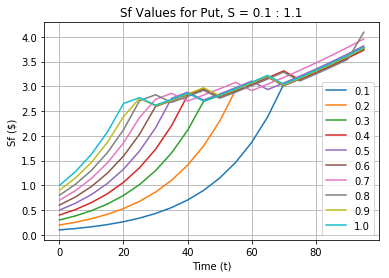

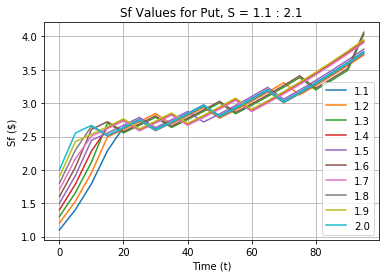

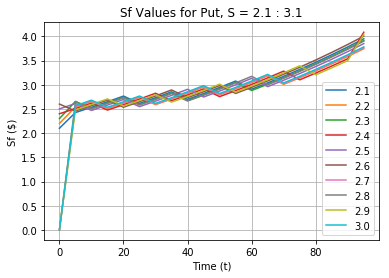

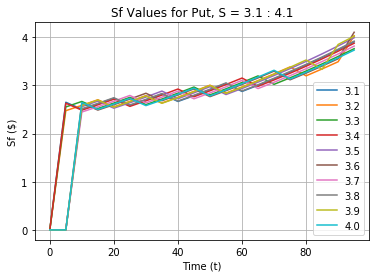

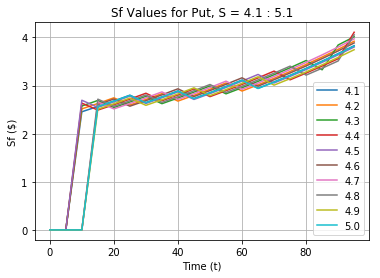

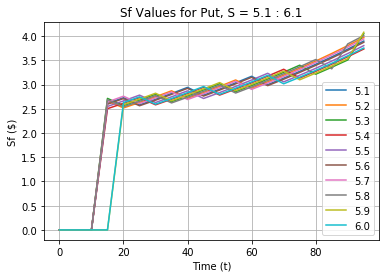

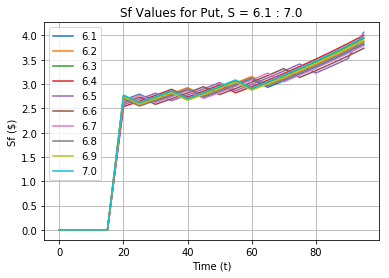

In [9]:
# plot of Sf over t, for varying spots
ind = 0
bunch = 10

sfPlot = plt.gca()
xlab = 'Time (t)'
ylab = 'Sf ($)'
for val in sfVals:
    sfPlot.plot(times, val, label=str(S[ind]))
    ind = ind + 1
    try:
        if ind % bunch == 0:
            sfPlot.set_xlabel(xlab)
            sfPlot.set_ylabel(ylab)
            plt.legend()
            title = 'Sf Values for Put, S = {:.1f} : {:.1f}'.format(S[ind-bunch],S[ind])
            plt.title(title)
            plt.grid()
            plt.show()
            sfPlot = plt.gca()
    except:
        sfPlot.set_xlabel(xlab)
        sfPlot.set_ylabel(ylab)
        plt.legend()
        title = 'Sf Values for Put, S = {:.1f} : {:.1f}'.format(S[ind-bunch],S[ind-1])
        plt.title(title)
        plt.grid()
        sfPlot = plt.gca()
plt.show()

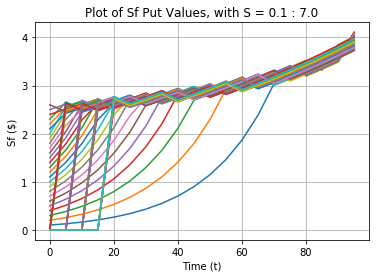

In [10]:
# show entire Sf values together
sfPlot = pd.DataFrame(sfVals).transpose()
sfPlot.columns = S
sfPlot['Time'] = times
sfPlot = sfPlot.set_index('Time')
title = 'Plot of Sf Put Values, with S = {:.1f} : {:.1f}'.format(S[0],S[-1])

plt.figure()
for i in sfPlot.columns:
    plt.plot(sfPlot[i],label=i)
plt.title(title)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()
plt.show()

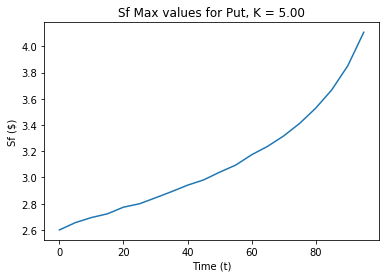

In [11]:
# find minimum Sft for each time t (for call)
sfMatrix = pd.DataFrame([])
for i in sfVals:
    sfMatrix = pd.concat([sfMatrix,pd.DataFrame(i)],axis=1)
sfFinal = sfMatrix.max(axis=1)

# plot Sft max values
title = 'Sf Max values for Put, K = {:.2f}'.format(K)
plt.title(title)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.plot(times,sfFinal)
plt.show()